In [ ]:
#-*- encoding: utf-8 -*-
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np

from google.colab import drive

import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,InceptionV3,densenet

In [ ]:
def top_5_accuracy(true, pred):
    return top_k_categorical_accuracy(true, pred, k=5)
def path_join(dirname, img_paths):
    return [os.path.join(dirname, img_path) for img_path in img_paths]

In [ ]:
if os.path.exists('/content/gdrive/')== False:
  drive.mount('/content/gdrive/')
  print('Google drive is mounted\n')
else:
  print('Google drive is already mounted\n')

Mounted at /content/gdrive/
Google drive is mounted



In [ ]:
#root Path 설정 및 각 데이터 배치 생성
rootPath = '/content/gdrive/My Drive/Food_Recognition/'

IMG_SIZE = (224, 224, 3)  
batch_size = 32
imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(
        rescale=1./255,
)
trainGen = imageGenerator.flow_from_directory(
   os.path.join(rootPath, 'train'),
     target_size=IMG_SIZE[:2],
     batch_size = batch_size,
     shuffle=True,
 )
validationGen = valid_datagen.flow_from_directory(
   os.path.join(rootPath, 'val'),
   target_size=IMG_SIZE[:2],
   batch_size=batch_size,
   shuffle=True,
)

Found 144272 images belonging to 170 classes.
Found 16980 images belonging to 170 classes.


In [ ]:
steps_train = trainGen.n / batch_size
steps_validate = validationGen.n / batch_size

cls_train = trainGen.classes
cls_validate = validationGen.classes

num_classes = trainGen.num_classes

https://github.com/hohoins/ml/tree/master/ImageBinaryGenerator


In [ ]:
class Model():
    def __init__(self, name,  params):
        assert name != '', "Model name needs to be specified"
        self.name = name
        self.trained = False   
        
    def construct_model(self):
        if self.name == 'Inception_v3':
            print('{:=^75}'.format('Downloading {}'.format(self.name)))
            self.base_model = InceptionV3(**params['network_params'])
            print('{:=^75}'.format('Download Complete'))
            
        elif self.name == 'DenseNet':
            print('{:=^75}'.format('Downloading {}'.format(self.name)))
            self.base_model = densenet.DenseNet169(**params['network_params'])
            print('{:=^75}'.format('Download Complete'))

        elif self.name == 'mobilenetv2':
            print('{:=^75}'.format('Downloading {}'.format(self.name)))
            self.base_model = MobileNetV2(**params['network_params'])
            print('{:=^75}'.format('Download Complete'))
        self.base_model.trainable = False    
        # 모델 구조  base model -> global average pooling -> dense
        print('{:=^75}'.format('Adding layers'))
        self.model = Sequential([
                self.base_model,
                GlobalAveragePooling2D(),
                Dense(params['num_classes'], activation='softmax')])
        print('{:=^75}'.format('Added layers'))
    
        # 지정 경로에 저장
        if not os.path.exists(rootPath + '/DenseNet/weight_path/'):
            os.mkdir(rootPath + '/DenseNet/weight_path/')
        self.weight_save_path = os.path.join(rootPath +'/DenseNet/weight_path/', self.name + "_weights.h5")
        
        print('{:=^75}'.format('Saving weights to {}'.format(self.weight_save_path)))
        self.model.save_weights(self.weight_save_path)
        print('{:=^75}'.format('Saved weights'))
    
    
    # train with feature extraction
    def train(self):
        if self.trained == True:
            self.model.load_weights(self.weight_save_path)
            self.trained = False
        
        # parma validation
        assert params['mode'] in ['fe', 'ft'], "mode must be either 'fe' or 'ft'"
        
        # 레이어 trainable 지정
        # feature extraction
        if params['mode'] == 'fe':
            self.model.trainable = False
            
        # finetuning
        elif params['mode'] == 'ft':
            self.model.trainable = True
    
            
        # compile the model with designated parameters    
        self.model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                           loss='categorical_crossentropy',
                           metrics=['categorical_accuracy', top_5_accuracy])
        
        if not os.path.exists(params['log_path']):
            os.mkdir(params['log_path'])
        
        if not os.path.exists(params['cp_path']):
            os.mkdir(params['cp_path'])
        
        # csv logger callback 
        log_path = os.path.join(params['log_path'], self.name + '_' + params['mode'] + '.log')
        csvlog_callback = CSVLogger(log_path)
        
        # checkpoint callback 
        cp_path = os.path.join(params['cp_path'], self.name + '_' + params['mode'] + '-{epoch:04d}-{val_loss:.2f}.h5')
        cp_callback = ModelCheckpoint(cp_path,
                                      mode="max",
                                      save_best_only=True)
        
        print('{:=^75}'.format('training {} with {}'.format(self.name, params['mode'])))
        # actual data fitting
        
        self.history = self.model.fit(trainGen, epochs=params['epoch'],
                                steps_per_epoch=steps_train,
                                validation_data=validationGen,
                                validation_steps=steps_validate,
                                callbacks=[cp_callback, csvlog_callback])
        # save model once done training    
        if not os.path.exists(params['model_path']):
            os.mkdir(params['model_path'])
            
        model_save_path = os.path.join(params['model_path'], self.name + '_' + params['mode'] + '.h5')
        self.model.save(model_save_path)
        self.trained = True

In [ ]:
params = {
    'num_classes': num_classes,
    'log_path': rootPath + 'DenseNet/log/',
    'cp_path': rootPath + 'DenseNet/check_point/',
    'model_path': rootPath + 'DenseNet/model/',
    'mode': 'ft',
    'learning_rate': 0.001,
    'epoch': 1,
    'network_params': {
    'include_top' : False, 
    'weights' : 'imagenet', 
    'input_shape' : IMG_SIZE
    }
}

In [ ]:
DenseNet = Model(name='DenseNet',  params=params)

In [ ]:
#retrain
model = keras.models.load_model(rootPath + 'DenseNet/check_point/DenseNet_ft-0001-2.78.h5', custom_objects={'top_5_accuracy':top_5_accuracy})
DenseNet.model = model


In [ ]:
DenseNet.construct_model()

===========================Downloading DenseNet============================
51879936/51877672 [==============================] - 0s 0us/step
=============================Download Complete=============================
===============================Adding layers===============================
===============================Added layers================================
Saving weights to /content/gdrive/My Drive/Food_Recognition//DenseNet/weight_path/DenseNet_weights.h5
===============================Saved weights===============================


In [ ]:
DenseNet.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 170)               283050    
Total params: 12,925,930
Trainable params: 12,767,530
Non-trainable params: 158,400
_________________________________________________________________


In [ ]:
DenseNet.train()

=========================training DenseNet with ft=========================
 143/4508 [..............................] - ETA: 10:50:01 - loss: 1.7550 - categorical_accuracy: 0.5334 - top_5_accuracy: 0.8217

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


 189/4508 [>.............................] - ETA: 10:51:17 - loss: 1.7460 - categorical_accuracy: 0.5365 - top_5_accuracy: 0.8218

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 6. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)


 345/4508 [=>............................] - ETA: 10:40:33 - loss: 1.7257 - categorical_accuracy: 0.5418 - top_5_accuracy: 0.8245

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2247/4508 [=============>................] - ETA: 5:54:34 - loss: 1.6291 - categorical_accuracy: 0.5643 - top_5_accuracy: 0.8422

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1498 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


4312/4508 [===========================>..] - ETA: 29:10 - loss: 1.5395 - categorical_accuracy: 0.5866 - top_5_accuracy: 0.8546

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)


4339/4508 [===========================>..] - ETA: 25:09 - loss: 1.5381 - categorical_accuracy: 0.5870 - top_5_accuracy: 0.8548

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


4450/4508 [============================>.] - ETA: 8:40 - loss: 1.5347 - categorical_accuracy: 0.5879 - top_5_accuracy: 0.8552

In [ ]:
model_save_path = os.path.join(params['model_path'], DenseNet.model.name + 'true_' + params['mode'] + '.h5')
DenseNet.model.save(model_save_path)
DenseNet.trained = True

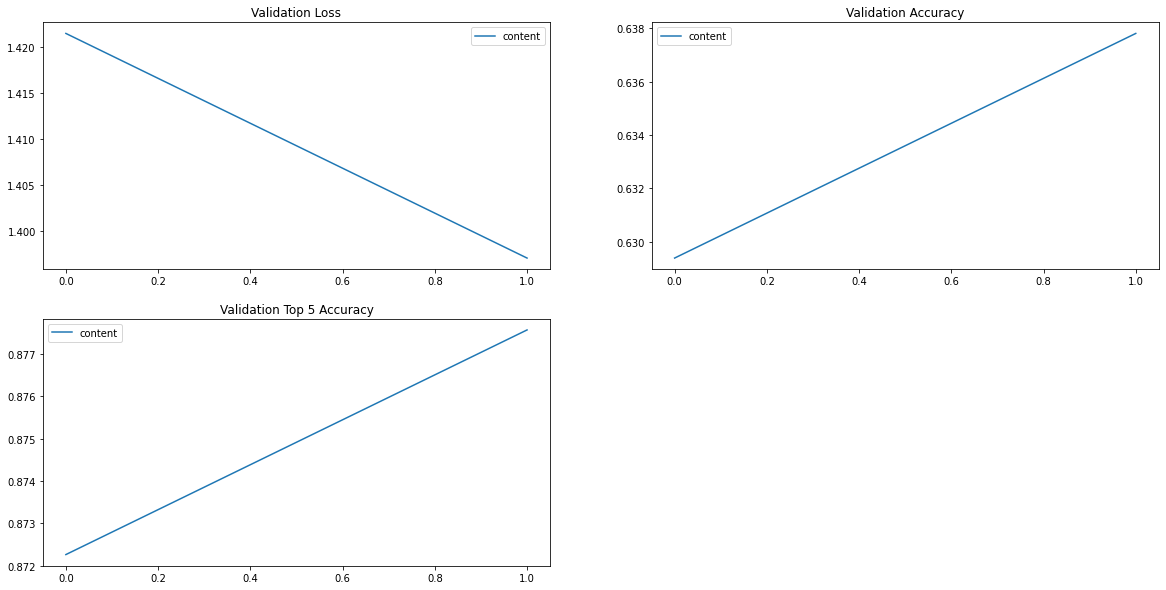

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

headers = [
    'epoch',
    'categorical_accuracy',
    'loss',
    'top_5_accuracy',
    'val_categorical_accuracy',
    'val_loss',
    'val_top_5_accuracy'
]

#inceptionv3_fe_log = 'log/inceptionv3_fe.log'
#inceptionv3_ft_log = 'log/inceptionv3_ft.log'
DenseNet_fe_log =  rootPath + 'DenseNet/log/DenseNet_fe.log'
 #MobilenetV2_ft_log = 'log/ MobilenetV2_ft.log'

logs = [DenseNet_fe_log]

legends = [log.split('/')[1].split('.log')[0] for log in logs]

fig = plt.figure(figsize=(20,10))
for log in logs:
    df = pd.read_csv(log)
    # val loss subplot
    plt.subplot(2,2,1)
    plt.title('Validation Loss')
    plt.plot(df.epoch, df.val_loss)
    plt.legend(legends)
    
    # val accuracy subplot
    plt.subplot(2,2,2)
    plt.title('Validation Accuracy')
    plt.plot(df.epoch, df.val_categorical_accuracy)
    plt.legend(legends)
    
    # val top 3 accuracy subplot
    plt.subplot(2,2,3)
    plt.title('Validation Top 5 Accuracy')
    plt.plot(df.epoch, df.val_top_5_accuracy)
    plt.legend(legends)

plt.show()


In [ ]:

testGen = valid_datagen.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=IMG_SIZE[:2],
    batch_size=batch_size,
)

Found 33829 images belonging to 170 classes.


In [ ]:
def plot_images(images, cls_true, cls_pred):
    
    assert len(images) == len(cls_true)
    if len(images) == 0: return

    num_x_plot = int(np.ceil(len(images)/5))
    fig, axes = plt.subplots(num_x_plot , 5 , figsize=(22,len(images)))
    interpolation = 'spline16'

    fig.subplots_adjust(hspace=0.6)
  
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], interpolation=interpolation)
            cls_pred_name = cls_pred.argsort(axis=1)[i][-3:][::-1]
            cls_pred_prob = np.sort(cls_pred, axis=1)[i][-3:][::-1]
            cls_true_name = cls_true[i]
            xlabel = ""
            for idx, class_name in enumerate(cls_pred_name):
                xlabel += "Pred {} : {}, score: {:.04f} \n".format(idx, idx_cls[class_name], cls_pred_prob[idx])
                xlabel += "True:{}".format(idx_cls[cls_true_name])
                ax.set_xlabel(xlabel, fontsize=15.0)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    
def load_images(image_paths):
    images = [plt.imread(path) for path in image_paths]
    return np.asarray(images)

def print_errors(class_num, cls_test, cls_pred, size=15):
    generator_test.reset()

    cls_pred_argmax = cls_pred.argmax(axis=1) # 예측 클래스 어래이
    incorrect = (cls_pred_argmax != cls_test) # 틀린 예측 인덱스
    true_incorrect = cls_test[incorrect]
    pred_incorrect = cls_pred_argmax[incorrect]

    pred_idx = np.argwhere(pred_incorrect == class_num).flatten() 

    print('예측 틀린 개수:{}'.format(len(pred_idx)))

    rdm_idx = np.random.randint(0, len(pred_idx), size)
    # 틀린 index 중 주어진 카테고리 번호의 prediction 이 틀린 index 중 랜덤한 size개의 index의 image_path
    image_path = np.array(path_join(test_dir_name, generator_test.filenames))[incorrect][pred_idx][rdm_idx]
    image = load_images(image_path)

    true_incorrect = true_incorrect[pred_idx][rdm_idx]
    pred_incorrect = cls_pred[incorrect][pred_idx][rdm_idx]

    plot_images(images=image, cls_true=true_incorrect, cls_pred=pred_incorrect)
    
    
def print_confusion_matrix(cls_test, cls_pred, labels, labels_actual):
  
    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred.argmax(axis=1),
                          labels=labels)
    
    true_pos = np.diag(cm)
    true_pos_false_pos = np.sum(cm, axis=0).astype(float)
    true_pos_false_neg = np.sum(cm, axis=1).astype(float)

    precision = true_pos / (true_pos_false_pos)
    recall = true_pos / (true_pos_false_neg)

    # please take care of divison by zero
    precision[np.isnan(precision)] = 0.0
    recall[np.isnan(recall)] = 0.0

    plt.figure(figsize=(20,10))
    sns.heatmap(cm, 
                annot=True, 
                xticklabels=label_actual, 
                yticklabels=label_actual, 
                fmt='g')

    plt.xlabel("predicted label")
    plt.ylabel("actual label")
    
    for i, class_name in enumerate(label_actual):
        print("({0}) {1}: recall={2:.2f}, precision={3:.2f}".format(i, class_name , recall[i], precision[i]))

In [ ]:
testGen.class_indices

{'aehobagbokk_eum': 0,
 'albab': 1,
 'apple_pie': 2,
 'baby_back_ribs': 3,
 'baechugimchi': 4,
 'baeggimchi': 5,
 'beef_carpaccio': 6,
 'bibimbab': 7,
 'bossam': 8,
 'breakfast_burrito': 9,
 'bulgogi': 10,
 'cheesecake': 11,
 'chicken_curry': 12,
 'chicken_quesadilla': 13,
 'chicken_wings': 14,
 'chocolate_cake': 15,
 'chocolate_mousse': 16,
 'chueotang': 17,
 'churros': 18,
 'club_sandwich': 19,
 'croque_madame': 20,
 'dalg_galbi': 21,
 'dalgbokk_eumtang': 22,
 'doenjangjjigae': 23,
 'dolajimuchim': 24,
 'dong_geulangttaeng': 25,
 'donuts': 26,
 'dubugimchi': 27,
 'dubujolim': 28,
 'dumplings': 29,
 'eomugbokk_eum': 30,
 'escargots': 31,
 'fish_and_chips': 32,
 'foie_gras': 33,
 'french_fries': 34,
 'french_toast': 35,
 'fried_calamari': 36,
 'frozen_yogurt': 37,
 'gajibokk_eum': 38,
 'galbigu_i': 39,
 'galbijjim': 40,
 'galbitang': 41,
 'gamjachaebokk_eum': 42,
 'gamjajeon': 43,
 'gamjajolim': 44,
 'gamjatang': 45,
 'ganjang_gejang': 46,
 'garlic_bread': 47,
 'geonsaeubokk_eum': 48,


In [ ]:
step_size = testGen.n/batch_size + 1

In [ ]:
def top_5_accuracy(true, pred):
    return top_k_categorical_accuracy(true, pred, 5)
model = DenseNet.model

In [ ]:
cls_pred = model.predict(testGen, steps=step_size, verbose=1)

  96/1058 [=>............................] - ETA: 2:37:50

In [ ]:
label = np.sort(testGen.class_indices.values())
label_actual = np.sort(testGen.class_indices.keys())

In [ ]:
cls_test = testGen.classes
cls_pred_classes = cls_pred.argsort(axis=1)

In [ ]:
idx_cls = {v:k for k,v in testGen.class_indices.items()}

In [ ]:
idx_cls

In [ ]:
def path_join(dirname, img_paths):
  return [os.path.join(dirname, img_path) for img_path in img_paths]

def print_confusion_matrix(cls_test, cls_pred, label, label_actual):
  
  cm = confusion_matrix(y_true=cls_test,
                        y_pred=cls_pred.argmax(axis=1),
                        labels=label)
  true_pos = np.diag(cm)
  true_pos_false_pos = np.sum(cm, axis=0).astype(float)
  true_pos_false_neg = np.sum(cm, axis=1).astype(float)

  precision = true_pos / (true_pos_false_pos)
  recall = true_pos / (true_pos_false_neg)
  
  # please take care of divison by zero
  precision[np.isnan(precision)] = 0.0
  recall[np.isnan(recall)] = 0.0

  plt.figure(figsize=(20,10))
  sns.heatmap(cm, annot=True, xticklabels=label_actual, yticklabels=label_actual, fmt='g', cmap='terrain')

  plt.xlabel("predicted label")
  plt.ylabel("actual label")  
  for i, class_name in enumerate(label_actual):
    print("({0}) {1}: recall={2:.2f}, precision={3:.2f}".format(i, class_name , recall[i], precision[i]))

def load_images(image_paths):
  images = [plt.imread(path) for path in image_paths]
  return np.asarray(images)

def plot_images(images, cls_true, cls_pred):
  assert len(images) == len(cls_true)
  if len(images) == 0: return
  
  num_x_plot = int(np.ceil(len(images)/4))
  fig, axes = plt.subplots(num_x_plot , 4 , figsize=(22,len(images)))
  interpolation = 'spline16'
  
  fig.subplots_adjust(hspace=0.6)
  
  for i, ax in enumerate(axes.flat):
    if i < len(images):
      ax.imshow(images[i], interpolation=interpolation)
      cls_pred_name = cls_pred.argsort(axis=1)[i][-3:][::-1]
      cls_pred_prob = np.sort(cls_pred, axis=1)[i][-3:][::-1]
      cls_true_name = cls_true[i]
      xlabel = ""
      for idx, class_name in enumerate(cls_pred_name):
        xlabel += "Pred {} : {}, score: {:.04f} \n".format(idx, idx_cls[class_name], cls_pred_prob[idx])
      xlabel += "True:{}".format(idx_cls[cls_true_name])
      ax.set_xlabel(xlabel, fontsize=15.0)
    ax.set_xticks([])
    ax.set_yticks([])
  plt.tight_layout()
  plt.show()
  

def print_errors(class_name):
  generator_test.reset()

  cls_pred_argmax = cls_pred.argmax(axis=1) # 예측 클래스 어래이
  incorrect = (cls_pred_argmax != cls_test) # 틀린 예측 인덱스
  true_incorrect = cls_test[incorrect]
  pred_incorrect = cls_pred_argmax[incorrect]
  
  pred_idx = np.argwhere(pred_incorrect == class_name).flatten() 
 
  print('예측 틀린 개수:{}'.format(len(pred_idx)))
  
  rdm_idx = np.random.randint(0, len(pred_idx), size=12)
  image_path = np.array(path_join(test_dir_name, generator_test.filenames))[incorrect][pred_idx][rdm_idx]
  image = load_images(image_path)
  
  true_incorrect = true_incorrect[pred_idx][rdm_idx]
  pred_incorrect = cls_pred[incorrect][pred_idx][rdm_idx]
  
  plot_images(images=image, cls_true=true_incorrect, cls_pred=pred_incorrect)

In [ ]:
print_confusion_matrix(cls_test, cls_pred, label, label_actual)

In [ ]:
print_errors(1)

In [ ]:
print_errors(2)

In [ ]:
 # testGen 정확도
test_steps=len(testGen)

loss0,accuracy0 = model.evaluate(testGen,batch_size=32, steps = test_steps)
print("checkPoint loss: {:.2f}".format(loss0))
print("checkPoint accuracy: {:.2f}".format(accuracy0)) 